In [1]:
%matplotlib inline

In [6]:
print(__doc__)

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

#from sklearn import datasets
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from QSAR.TFNN.nnfunseni import *
from sklearn.model_selection import cross_validate, cross_val_predict
from scipy.stats import spearmanr

Automatically created module for IPython interactive environment


Using TensorFlow backend.


In [7]:
def plot_regression_results(ax, y_true, y_pred, title, scores):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
#    ax.set_xlim([y_true.min(), y_true.max()])
#    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Scaled NEMD CoF')
    ax.set_ylabel('Scaled Predicted CoF')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='best')
#    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)

In [48]:
def find_best(X,y):
    lasso = Lasso(random_state=0, max_iter=10000)
    alphas = np.logspace(-4, -0.5, 30)
#    alphas = np.logspace(100, 10, 300)
    tuned_parameters = [{'alpha': alphas}]
    n_folds = 10

    clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=True)
    clf.fit(X, y)
    scores = clf.cv_results_['mean_test_score']
    scores_std = clf.cv_results_['std_test_score']
    plt.figure().set_size_inches(8, 6)
    plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
    std_error = scores_std / np.sqrt(n_folds)

    plt.semilogx(alphas, scores + std_error, 'b--')
    plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
    plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

    plt.ylabel('CV score +/- std error')
    plt.xlabel('alpha')
    plt.axhline(np.max(scores), linestyle='--', color='.5')
    plt.xlim([alphas[0], alphas[-1]])

    plt.show()
    
    best_lasso=clf.best_estimator_
    best_alpha=clf.best_params_
    
    return best_lasso,best_alpha

In [9]:
def plot_LASSO_pie(featuredict,cutoff):
    #separate postive and negative coefficients
    pos_f={}
    neg_f={}
    for feat in featuredict.keys():
        if featuredict[feat] < -cutoff:
            neg_f.update({feat:featuredict[feat]})
        if featuredict[feat] > cutoff:
            pos_f.update({feat:featuredict[feat]})
    #normalize the coefficients based on the size features
    neg_f_sum=np.sum(list(neg_f.values()))
    pos_f_sum=np.sum(list(pos_f.values()))
    for feat in pos_f.keys():
        pos_f[feat] = pos_f[feat]/pos_f_sum*len(pos_f)
    for feat in neg_f.keys():
        neg_f[feat] = neg_f[feat]/neg_f_sum*len(neg_f)
    #plot pie chart
    #define colors
    def make_rgb_transparent(rgb, bg_rgb, alpha):
        return [alpha * c1 + (1 - alpha) * c2
                for (c1, c2) in zip(rgb, bg_rgb)]
    red = np.divide([float(255), float(0), float(0)],float(255))
    orange = np.divide([float(255), float(165), float(0)],float(255))
    green = np.divide([float(0), float(196), float(64)],float(255))
    blue = np.divide([float(0), float(0), float(255)],float(255))
    gray = np.divide([float(140), float(140), float(140)],float(255))
    white = [1, 1, 1]
    first_colors = [blue, red]
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = 'positive','negative'
    sizes = [len(pos_f)/(len(featuredict))*100,len(neg_f)/(len(featuredict))*100]
    sub_sizes = list(pos_f.values())+list(neg_f.values())
    sub_labels = list(pos_f.keys())+list(neg_f.keys())
    colorlist =[]
    for i in list(pos_f.values()):
        colorlist.append(make_rgb_transparent(blue,white,i/len(pos_f)))
    for i in list(neg_f.values()):
        colorlist.append(make_rgb_transparent(red,white,i/len(neg_f)))
    #explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

    fig1, ax1 = plt.subplots()
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    #ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',colors=first_colors,
    #        shadow=True, startangle=90,)
    ax1.pie(sizes,labels=labels,colors=first_colors,startangle=90,radius=1.3,
            textprops={'fontsize': 50,'color':'black'},
        wedgeprops={"edgecolor":"1",'linewidth': 3,
                    'linestyle': 'solid', 'antialiased': True})
    ax1.pie(sub_sizes,labels=sub_labels,startangle=90,labeldistance=0.8,colors=colorlist,radius=1.3-0.3,
            textprops={'fontsize': 50,'color':'black'},
       wedgeprops={"edgecolor":"1",'linewidth': 3,
                    'linestyle': 'solid', 'antialiased': True})
    #plt.setp( ax1, width=0.3, edgecolor='white')
    plt.tight_layout()
#    plt.show()

In [63]:
def rank_features(df,t,s,c):
    X_train, X_test, y_train, y_test = train_test_split(
#    df.drop(labels=['OFR','target','cof','temp','speed','low.cov','med.cov',
#                    'thigh','tmed','tlow','vhigh','vmed','vlow'
#                   ], axis=1),
#    df.drop(labels=['OFR','target','cof','CO.double.bonds', 'tail.double.bonds',
#       'tail.side.chains', 'ofrgap', 'rgofr', 'rgsqu', 'noofrtop', 'noofrbot',
#       'nosqu', 'dens_max_top', 'dens_max_bot', 'dens_max_squ', 'Hz', 'ofrD',
#       'squD', 'ofr_bound_z'],axis=1),
    df.drop(labels=['OFR','cof','speed','temp','thigh','tmed','tlow',
                         'vhigh','vmed','vlow','low.cov','med.cov',
                        'dens_max_top','dens_max_bot','dens_max_squ',
                        'Hz','ofr_bound_z','ofrgap',#'noofrtop','noofrbot',
                   #'num.heavy.atom','heavy.atom.wt','TPSA'
                   ], axis = 1),
    df['cof'],
    test_size=0.3,
    random_state=0)

    train_data_x = X_train.values
    test_data_x = X_test.values
    train_data_y = y_train.values
    test_data_y = y_test.values

    m = np.shape(train_data_x)[0]
    d = np.shape(train_data_x)[1]
    p = 1

## seed 
    np.random.seed(3)

# non-dimenisionalization
    train_var_x = np.var(train_data_x,0)
    train_mean_x = np.mean(train_data_x,0).reshape(d,1)
    train_var_y = np.var(train_data_y,0).reshape(p,1)
    train_mean_y = np.mean(train_data_y,0).reshape(p,1)

    scaled_train_data_x = data_normalize(train_data_x,train_mean_x,train_var_x)
    scaled_train_data_y = data_normalize(train_data_y,train_mean_y,train_var_y).T
    scaled_test_data_x = data_normalize(test_data_x,train_mean_x,train_var_x)
    scaled_test_data_y = data_normalize(test_data_y,train_mean_y,train_var_y).T


    X = scaled_train_data_x
    y = scaled_train_data_y.reshape([-1])
    

    best_lasso,best_param = find_best(X,y)
    
    alpha = best_param['alpha']
    
    train_score=best_lasso.score(X,y)
    test_score=best_lasso.score(scaled_test_data_x,scaled_test_data_y)
    coeff_used = np.sum(best_lasso.coef_!=0)
    
    lfeatures=best_lasso.coef_[best_lasso.coef_ != 0]
    reserved_feats = X_train.columns[(best_lasso.coef_ != 0).ravel().tolist()]
    #reserved_feats

    y_pred_lasso = best_lasso.fit(X, y).predict(scaled_test_data_x)
    rscore,p = spearmanr(y_pred_lasso,scaled_test_data_y)
    
    y_pred_lasso=y_pred_lasso*np.sqrt(train_var_y)+train_mean_y
    
    fig, axs = plt.subplots()
    plt.rc('font', size=30)
    plt.rcParams["figure.figsize"] = (8,8)
    
    plot_regression_results(
        axs, test_data_y, y_pred_lasso,
        "LASSO",
        ('$R^2={:.2f}$'+'\n'+r'$\alpha={:.3f}$').format(rscore,alpha))
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig('LASSO_'+str(t)+'-'+str(s)+'ms'+c+'-pc-fit1.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

    fpairs = {}
    for i,f in enumerate(reserved_feats):
        fpairs.update({f:lfeatures[i]})
    featuredict = fpairs
    fpairs = sorted(fpairs.items(), key=lambda x: x[1])
    featuredict1 = {}
    for i,f in enumerate(reserved_feats):
        featuredict1.update({fpairs[i][0]:fpairs[i][1]})
    plot_LASSO_pie(featuredict1,0.01)
    plt.savefig('LASSO_coef_pie'+str(t)+'-'+str(s)+'ms'+c+'1.svg', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=False, bbox_inches='tight', pad_inches=0.1,
        frameon=None, metadata=None)

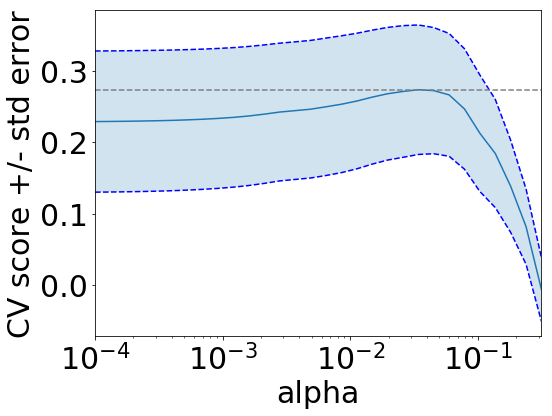

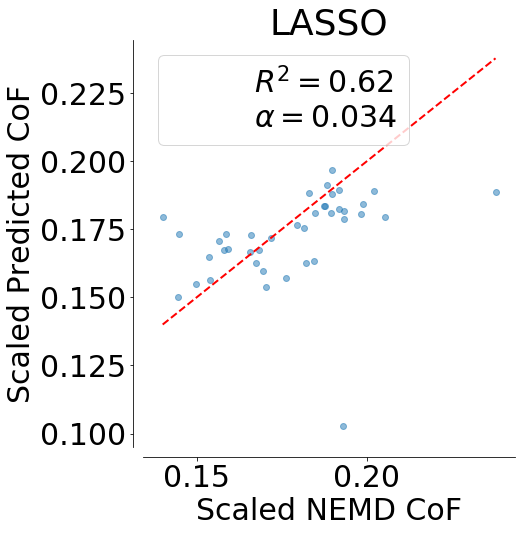

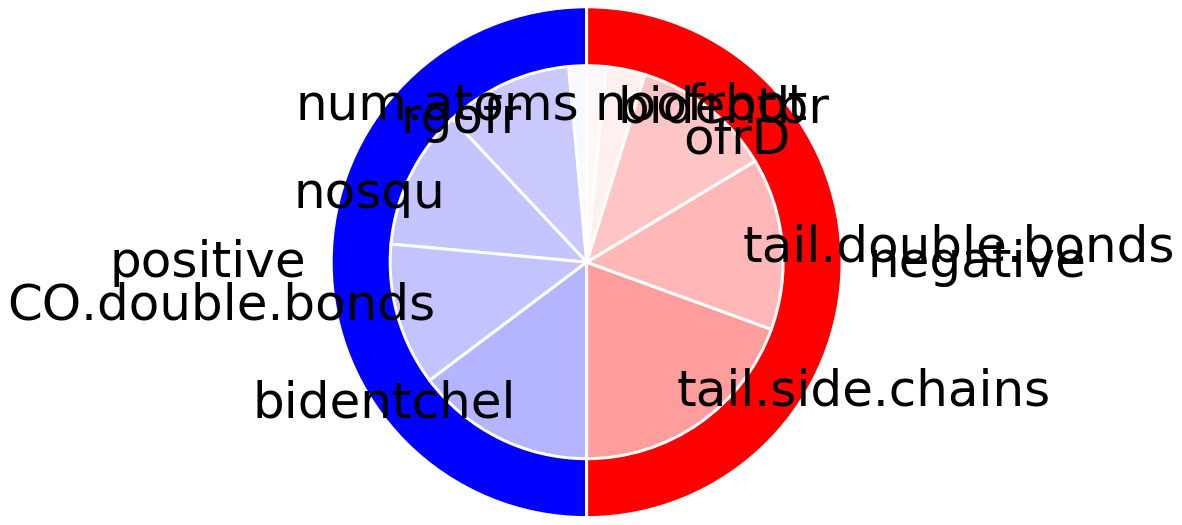

In [64]:
df1 = pd.read_excel('physprops-noRACs1.xlsx')
temp=45
sp=0.5
cov='low'
df1=df1.loc[(df1['temp']==temp)]
df1=df1.loc[df1['speed']==sp]
df1=df1.loc[df1[cov+'.cov']==1]
rank_features(df1,temp,sp,cov)

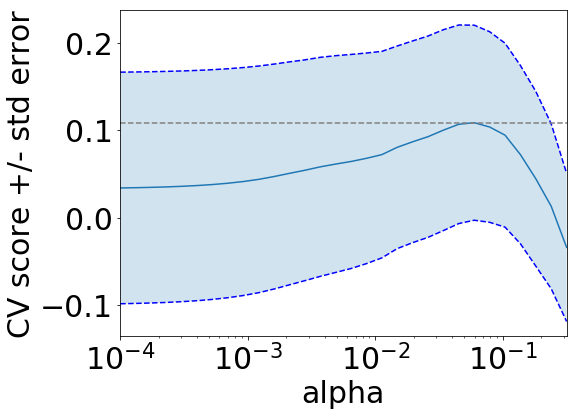

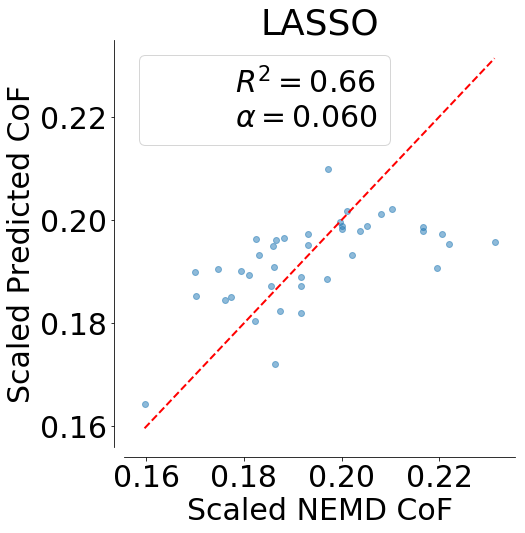

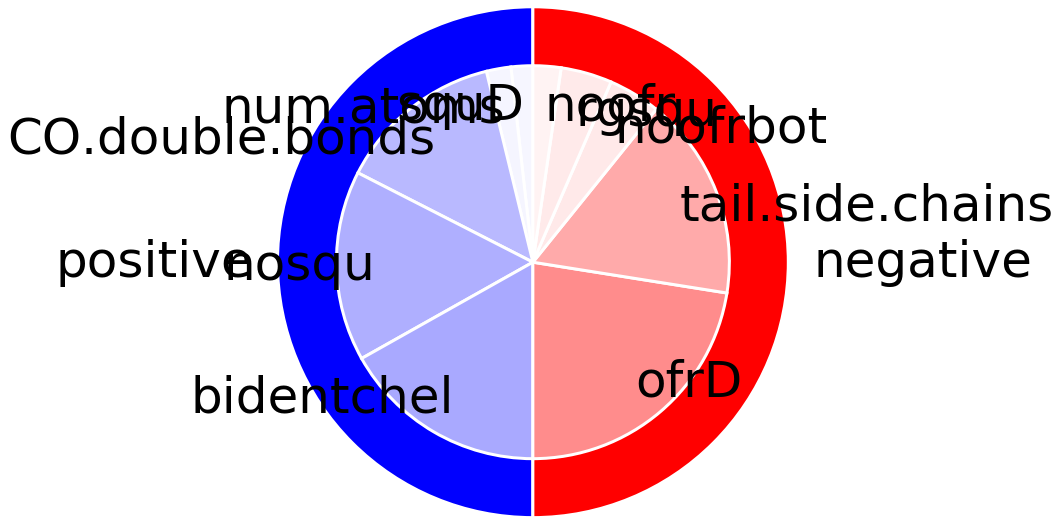

In [65]:
df1 = pd.read_excel('physprops-noRACs1.xlsx')
temp=45
sp=1
cov='low'
df1=df1.loc[(df1['temp']==temp)]
df1=df1.loc[df1['speed']==sp]
df1=df1.loc[df1[cov+'.cov']==1]
rank_features(df1,temp,sp,cov)

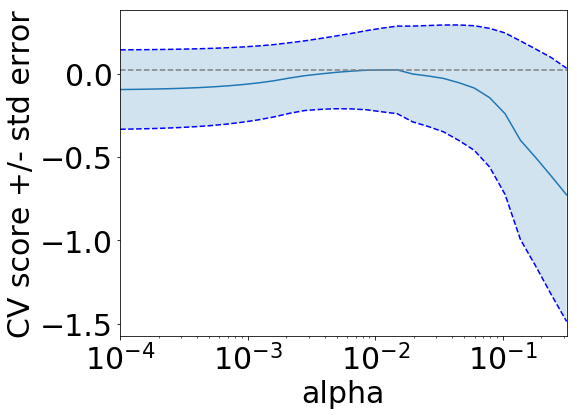

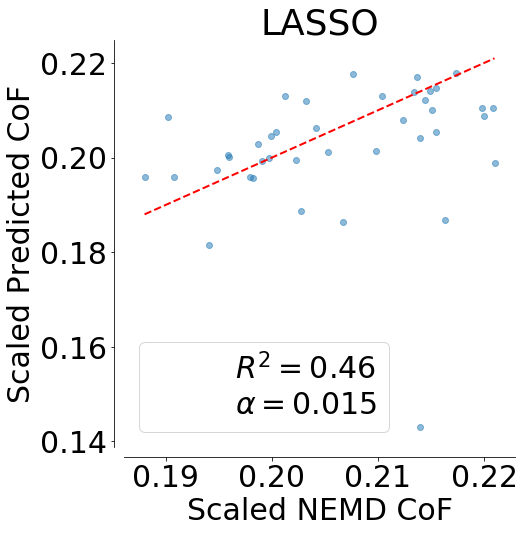

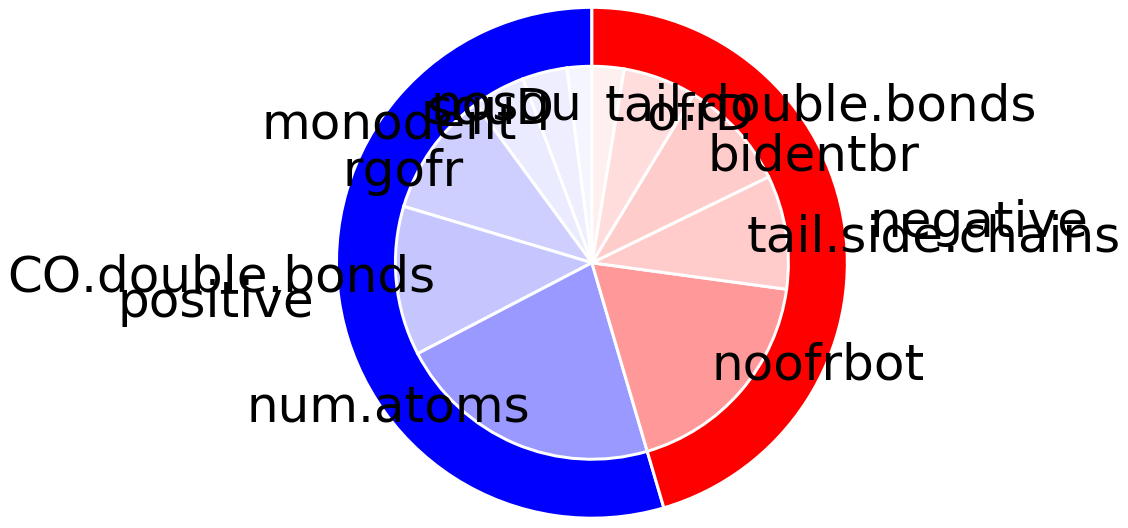

In [66]:
df1 = pd.read_excel('physprops-noRACs1.xlsx')
temp=45
sp=10
cov='low'
df1=df1.loc[(df1['temp']==temp)]
df1=df1.loc[df1['speed']==sp]
df1=df1.loc[df1[cov+'.cov']==1]
rank_features(df1,temp,sp,cov)

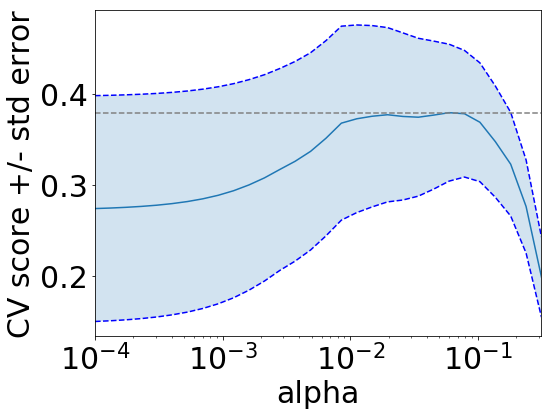

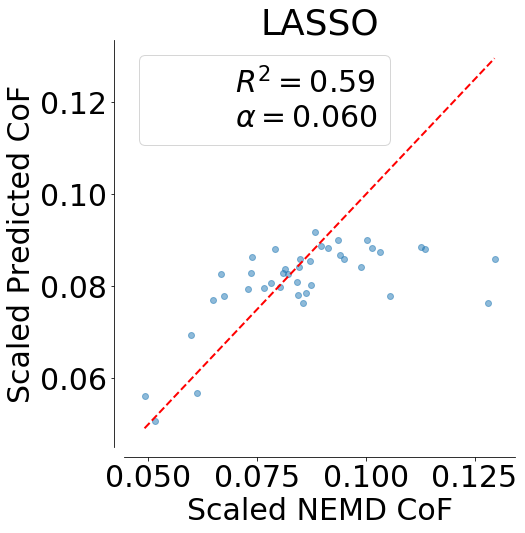

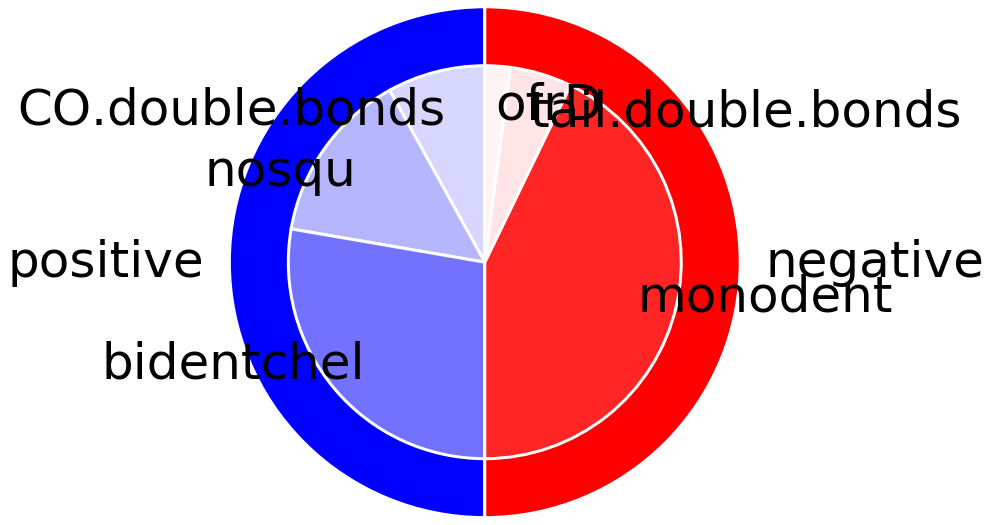

In [67]:
df1 = pd.read_excel('physprops-noRACs1.xlsx')
temp=120
sp=0.5
cov='low'
df1=df1.loc[(df1['temp']==temp)]
df1=df1.loc[df1['speed']==sp]
df1=df1.loc[df1[cov+'.cov']==1]
rank_features(df1,temp,sp,cov)

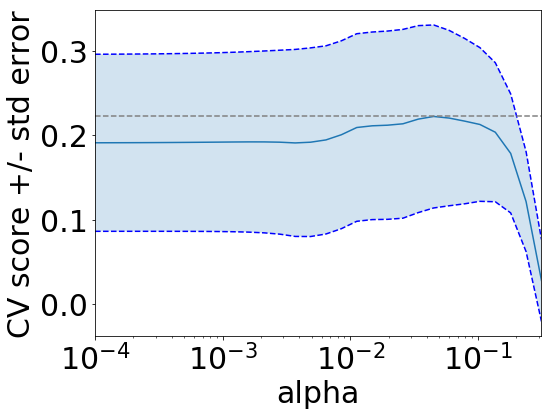

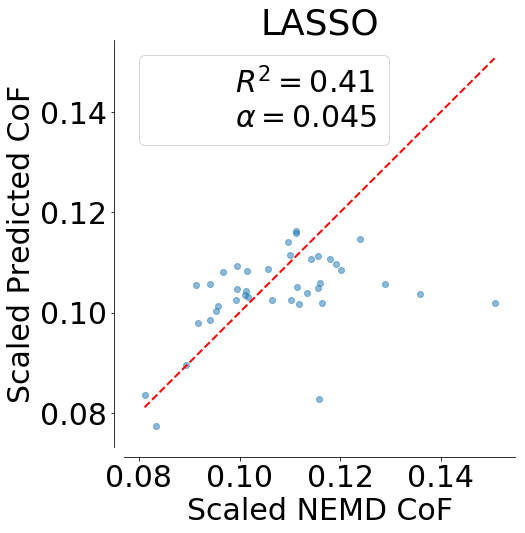

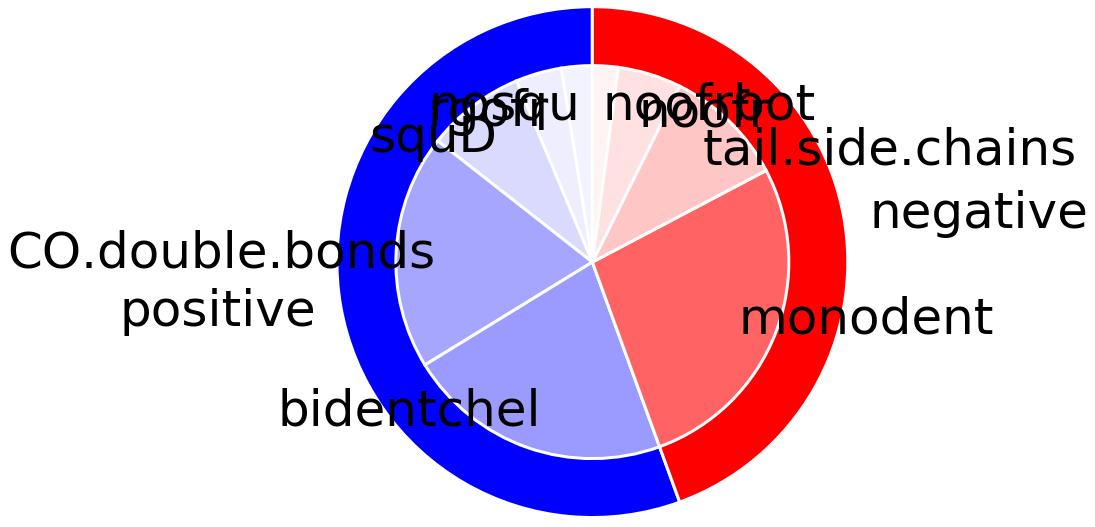

In [68]:
df1 = pd.read_excel('physprops-noRACs1.xlsx')
temp=120
sp=1
cov='low'
df1=df1.loc[(df1['temp']==temp)]
df1=df1.loc[df1['speed']==sp]
df1=df1.loc[df1[cov+'.cov']==1]
rank_features(df1,temp,sp,cov)

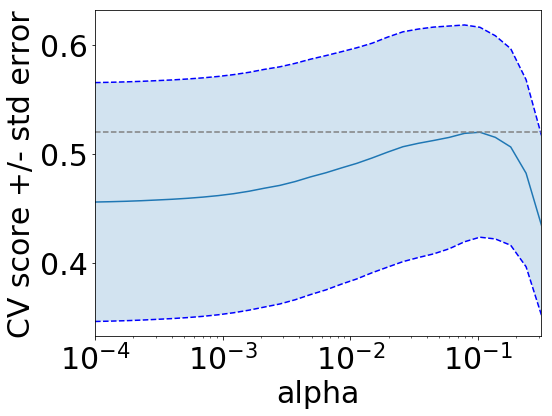

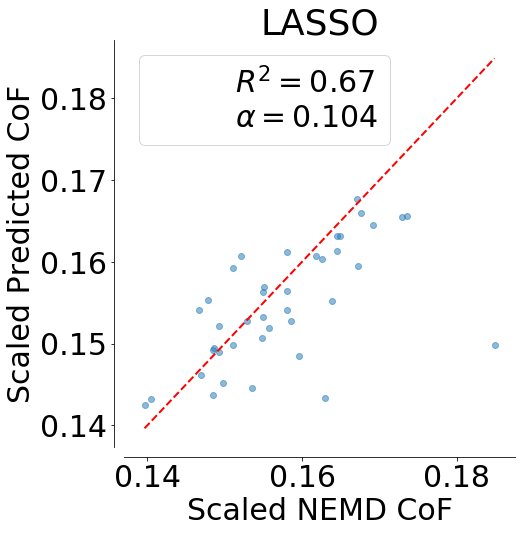

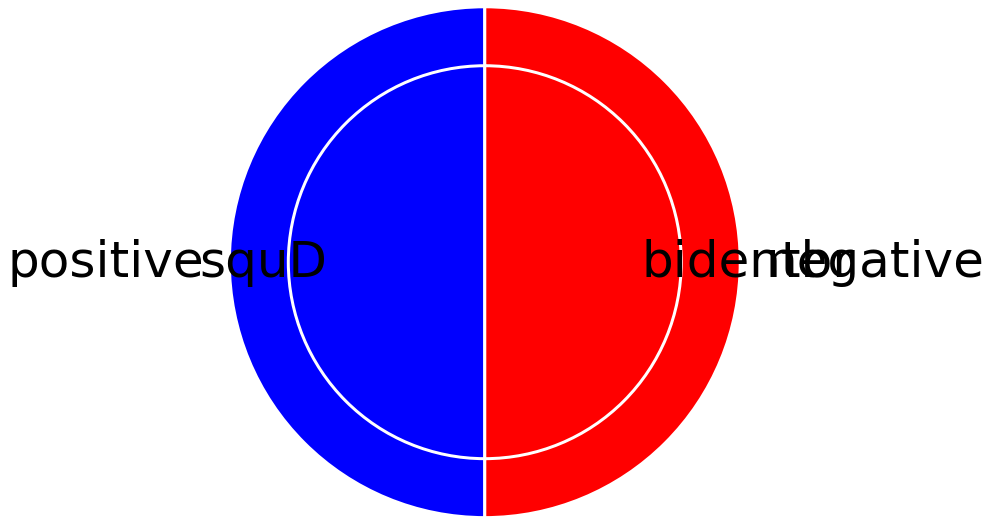

In [69]:
df1 = pd.read_excel('physprops-noRACs1.xlsx')
temp=120
sp=10
cov='low'
df1=df1.loc[(df1['temp']==temp)]
df1=df1.loc[df1['speed']==sp]
df1=df1.loc[df1[cov+'.cov']==1]
rank_features(df1,temp,sp,cov)

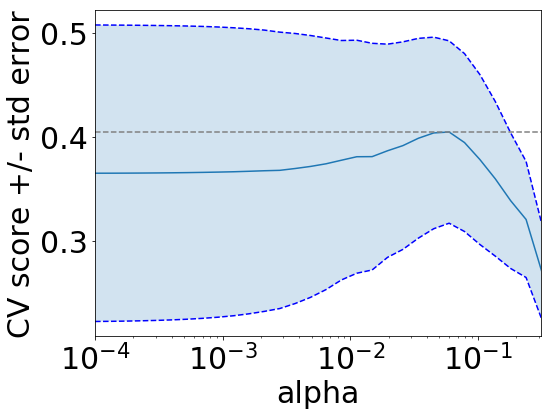

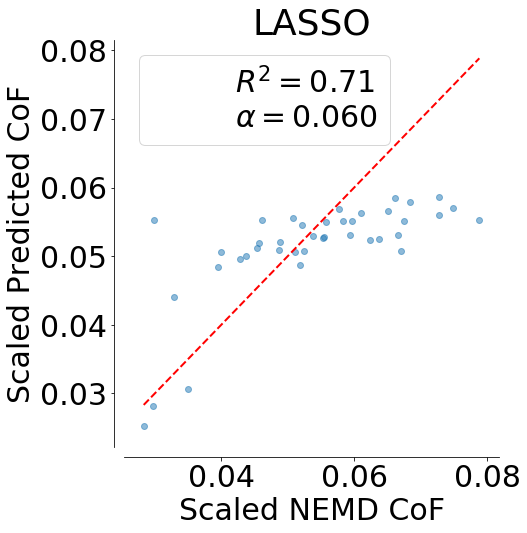

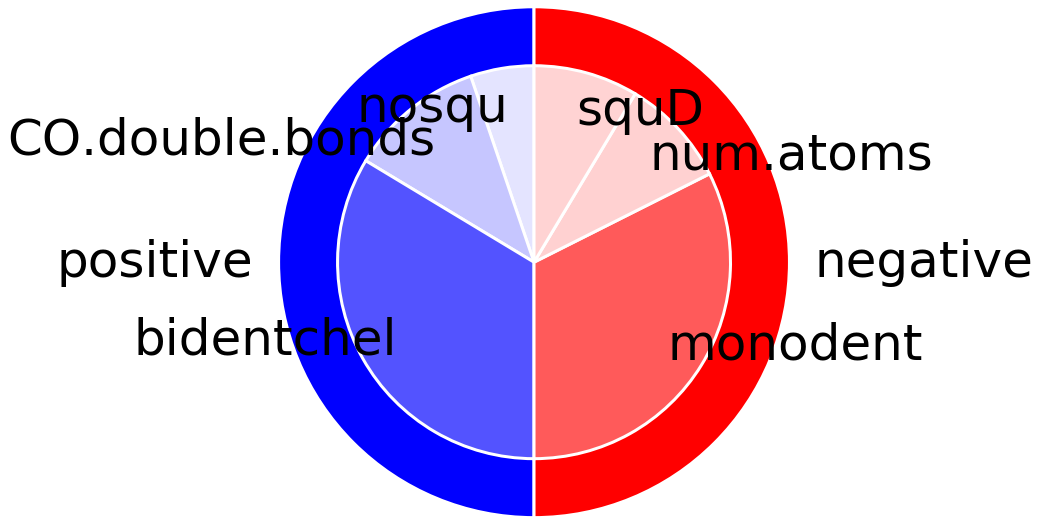

In [70]:
df1 = pd.read_excel('physprops-noRACs1.xlsx')
temp=150
sp=0.5
cov='low'
df1=df1.loc[(df1['temp']==temp)]
df1=df1.loc[df1['speed']==sp]
df1=df1.loc[df1[cov+'.cov']==1]
rank_features(df1,temp,sp,cov)

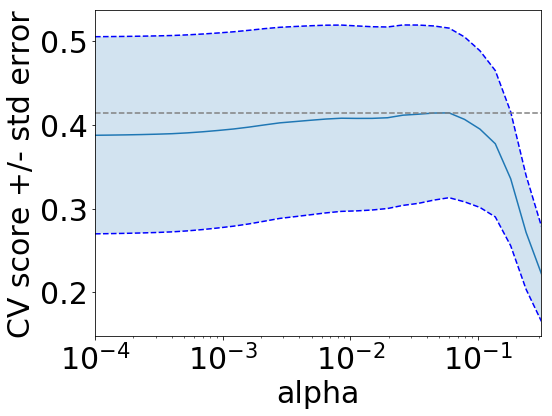

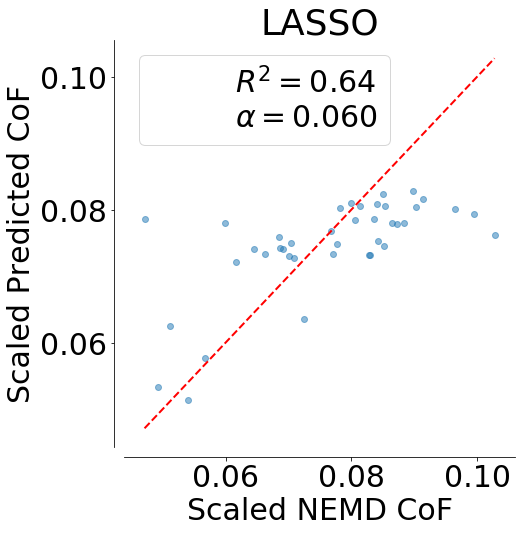

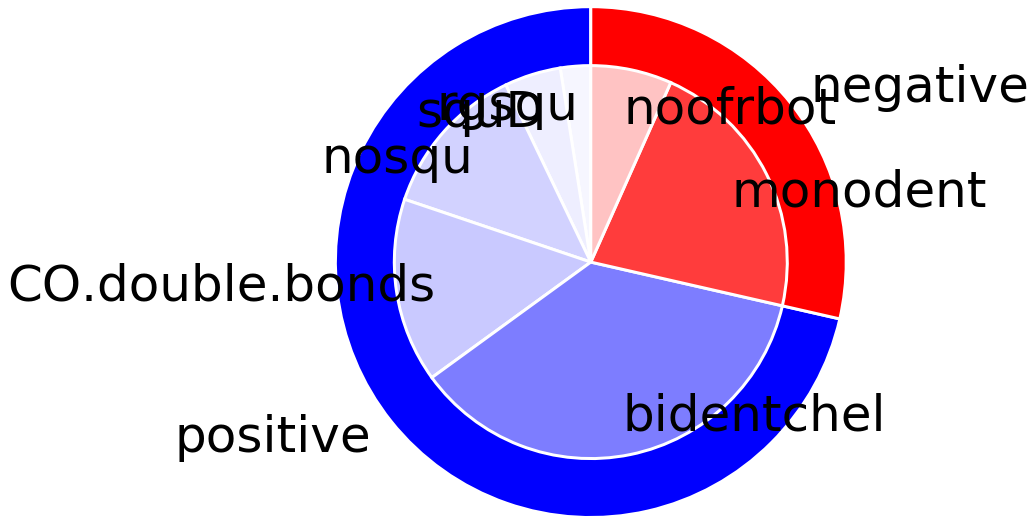

In [71]:
df1 = pd.read_excel('physprops-noRACs1.xlsx')
temp=150
sp=1
cov='low'
df1=df1.loc[(df1['temp']==temp)]
df1=df1.loc[df1['speed']==sp]
df1=df1.loc[df1[cov+'.cov']==1]
rank_features(df1,temp,sp,cov)

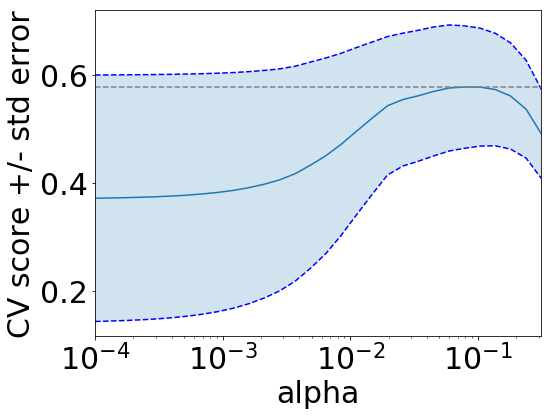

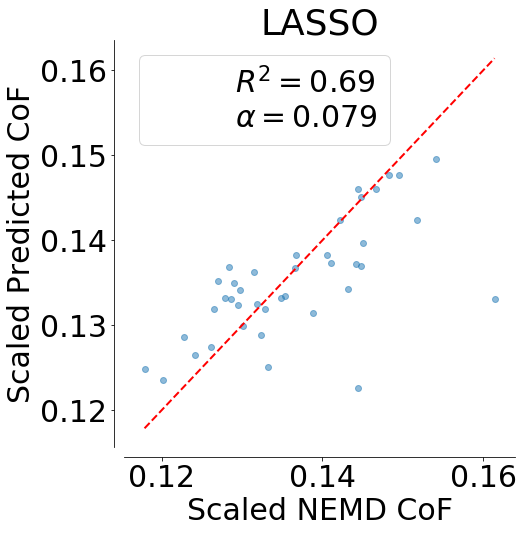

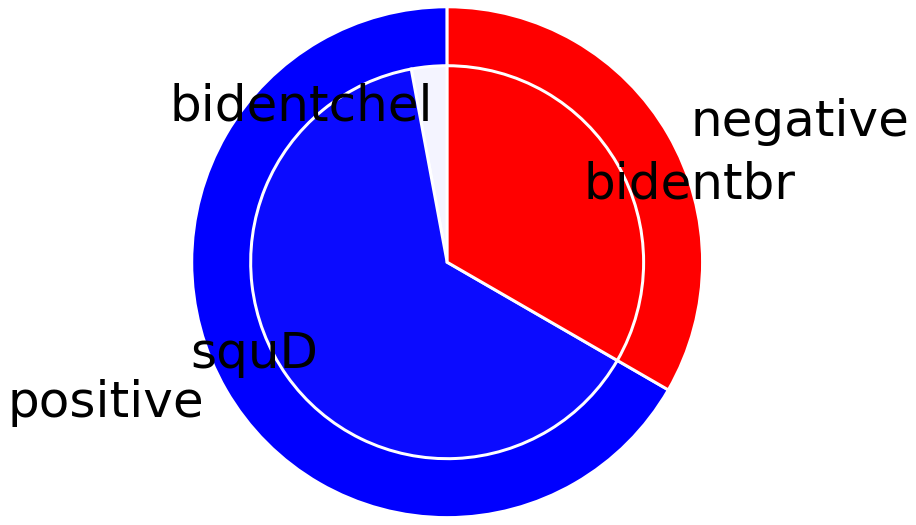

In [72]:
df1 = pd.read_excel('physprops-noRACs1.xlsx')
temp=150
sp=10
cov='low'
df1=df1.loc[(df1['temp']==temp)]
df1=df1.loc[df1['speed']==sp]
df1=df1.loc[df1[cov+'.cov']==1]
rank_features(df1,temp,sp,cov)

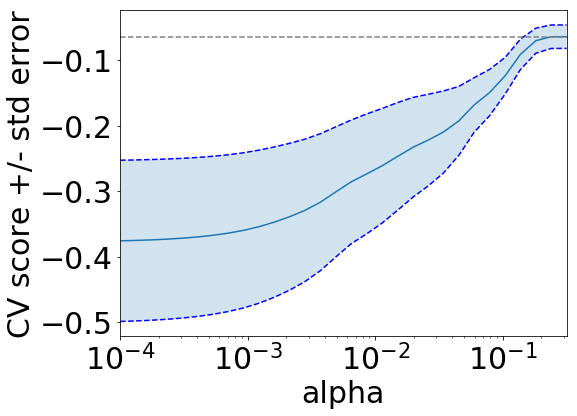

/Users/jing/anaconda3/envs/tkinter_test1/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/jing/anaconda3/envs/tkinter_test1/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/jing/anaconda3/envs/tkinter_test1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/jing/anaconda3/envs/tkinter_test1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/jing/anaconda3/envs/tkinter_test1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


ZeroDivisionError: division by zero

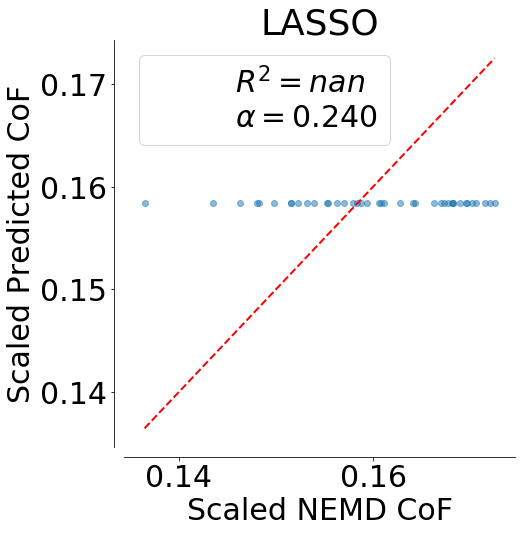

In [73]:
df1 = pd.read_excel('physprops-noRACs1.xlsx')
temp=45
sp=0.5
cov='med'
df1=df1.loc[(df1['temp']==temp)]
df1=df1.loc[df1['speed']==sp]
df1=df1.loc[df1[cov+'.cov']==1]
rank_features(df1,temp,sp,cov)

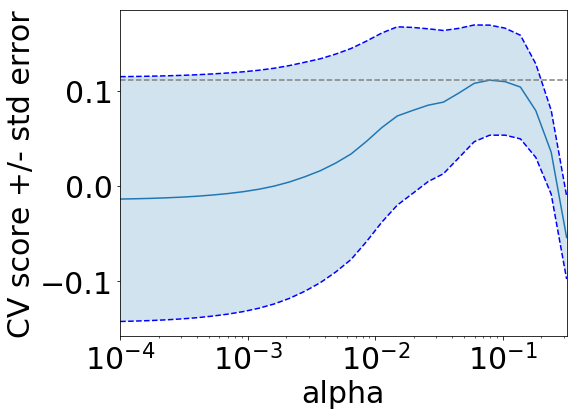

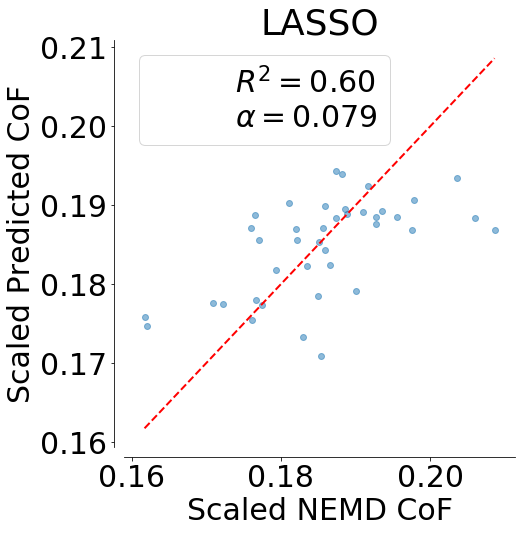

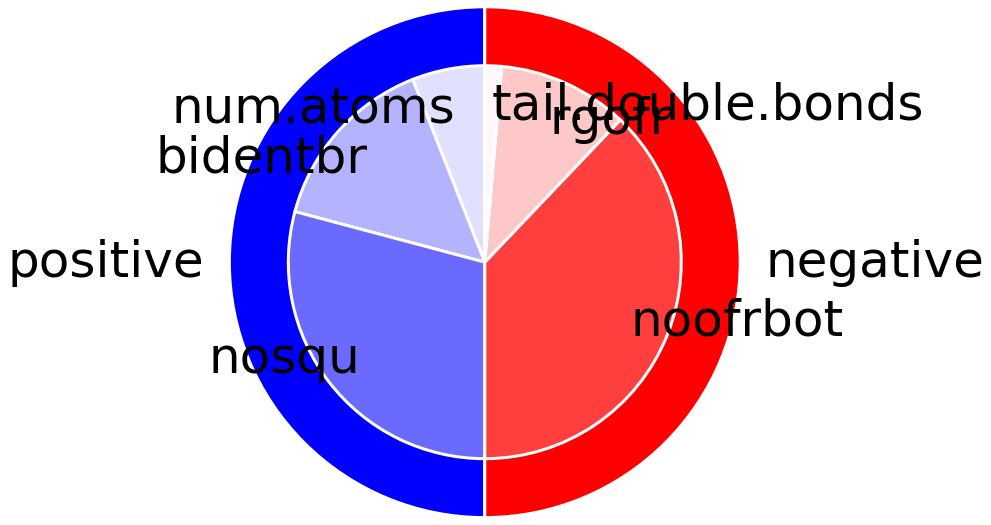

In [74]:
df1 = pd.read_excel('physprops-noRACs1.xlsx')
temp=45
sp=1
cov='med'
df1=df1.loc[(df1['temp']==temp)]
df1=df1.loc[df1['speed']==sp]
df1=df1.loc[df1[cov+'.cov']==1]
rank_features(df1,temp,sp,cov)

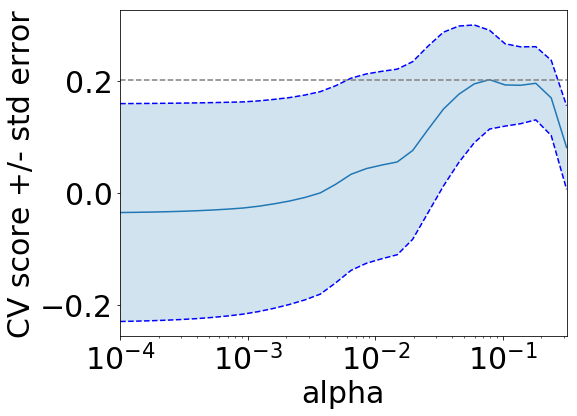

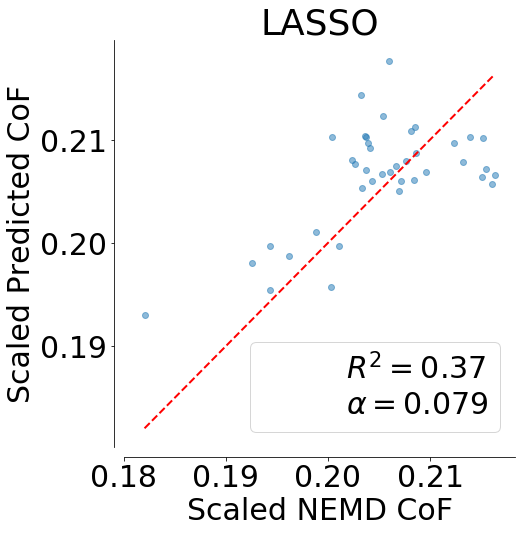

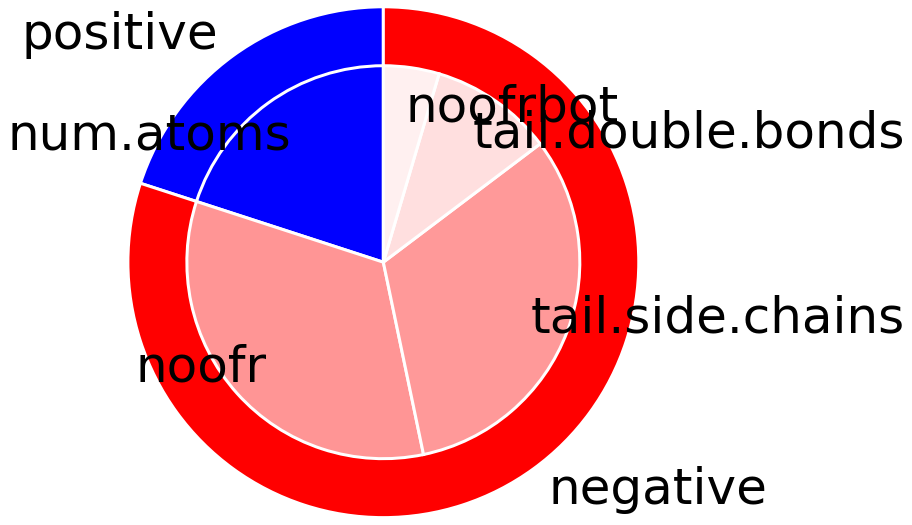

In [75]:
df1 = pd.read_excel('physprops-noRACs1.xlsx')
temp=45
sp=10
cov='med'
df1=df1.loc[(df1['temp']==temp)]
df1=df1.loc[df1['speed']==sp]
df1=df1.loc[df1[cov+'.cov']==1]
rank_features(df1,temp,sp,cov)

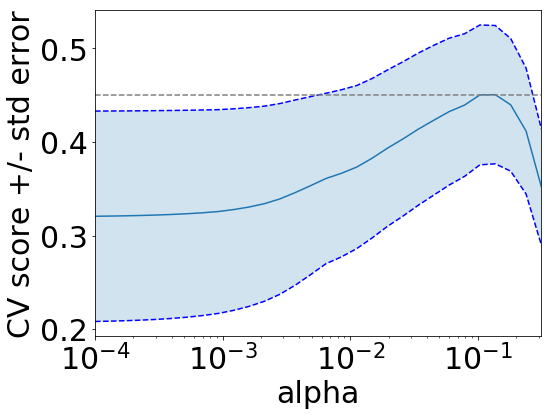

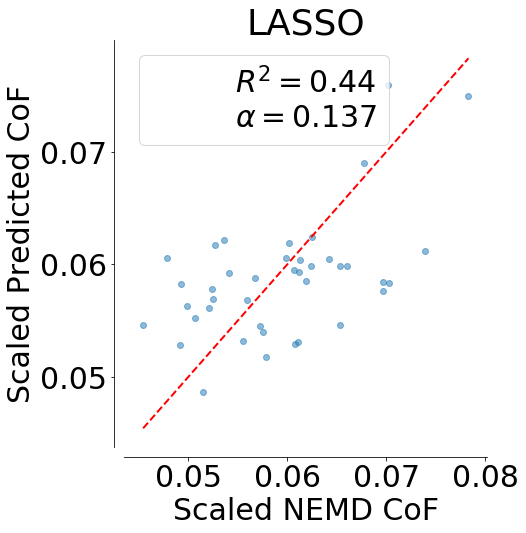

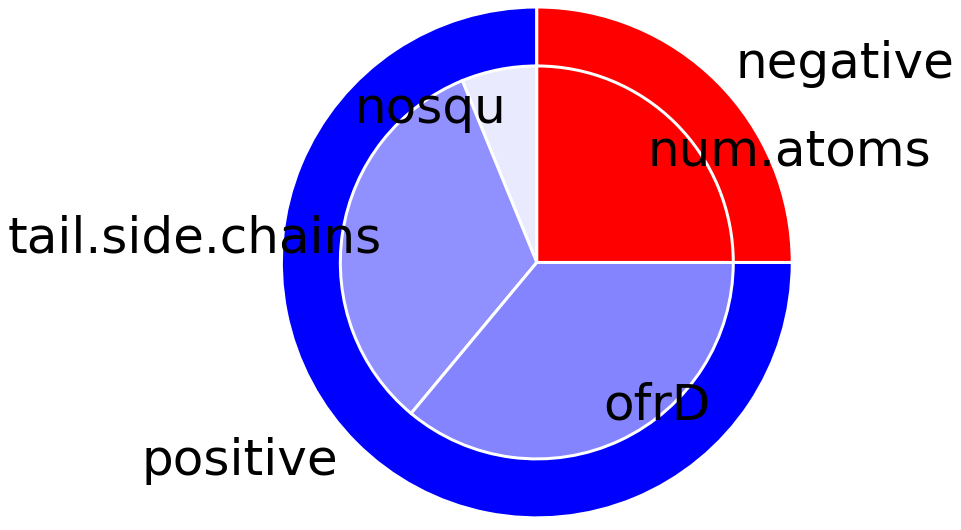

In [76]:
df1 = pd.read_excel('physprops-noRACs1.xlsx')
temp=120
sp=0.5
cov='med'
df1=df1.loc[(df1['temp']==temp)]
df1=df1.loc[df1['speed']==sp]
df1=df1.loc[df1[cov+'.cov']==1]
rank_features(df1,temp,sp,cov)

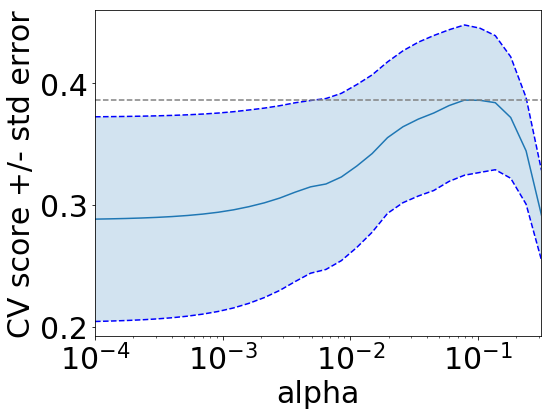

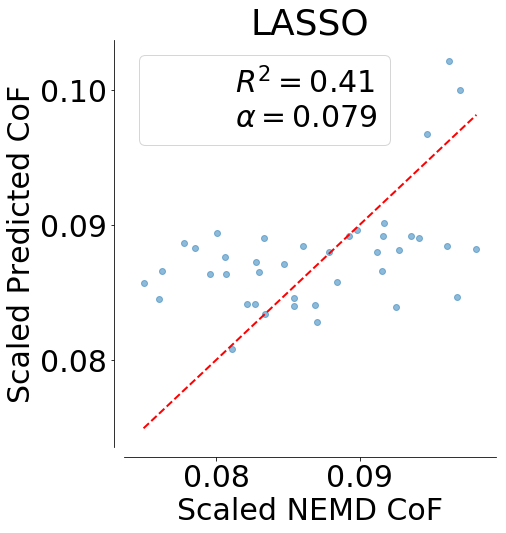

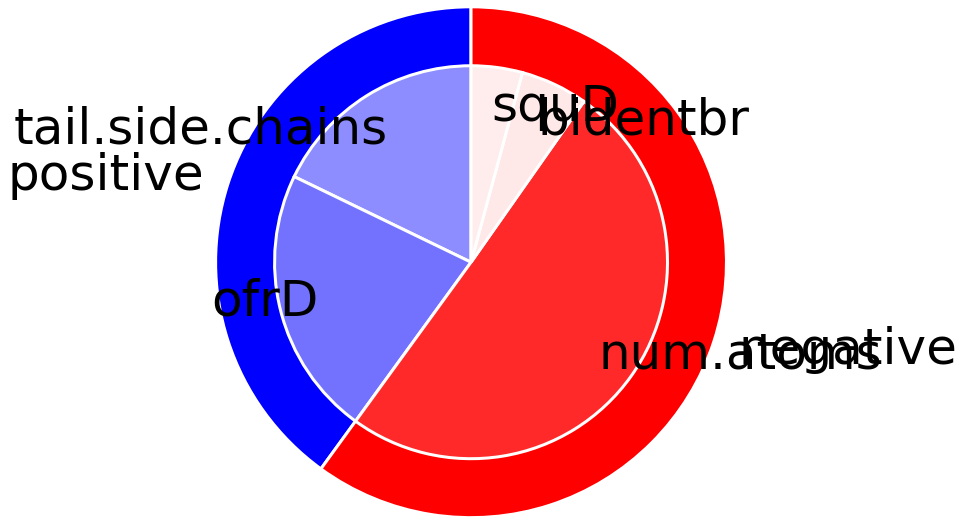

In [77]:
df1 = pd.read_excel('physprops-noRACs1.xlsx')
temp=120
sp=1
cov='med'
df1=df1.loc[(df1['temp']==temp)]
df1=df1.loc[df1['speed']==sp]
df1=df1.loc[df1[cov+'.cov']==1]
rank_features(df1,temp,sp,cov)

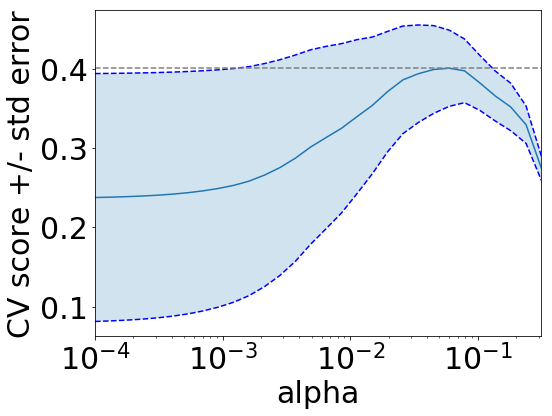

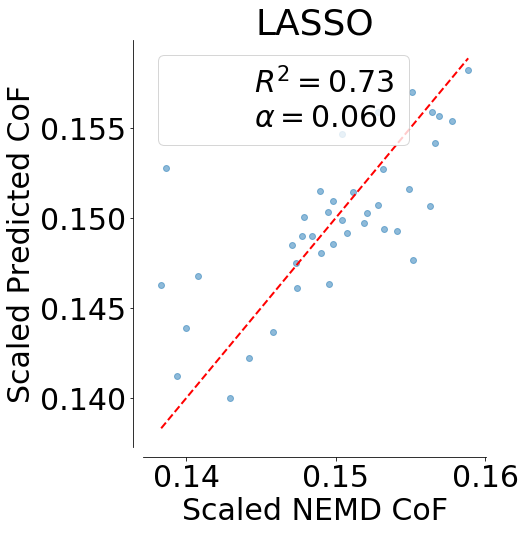

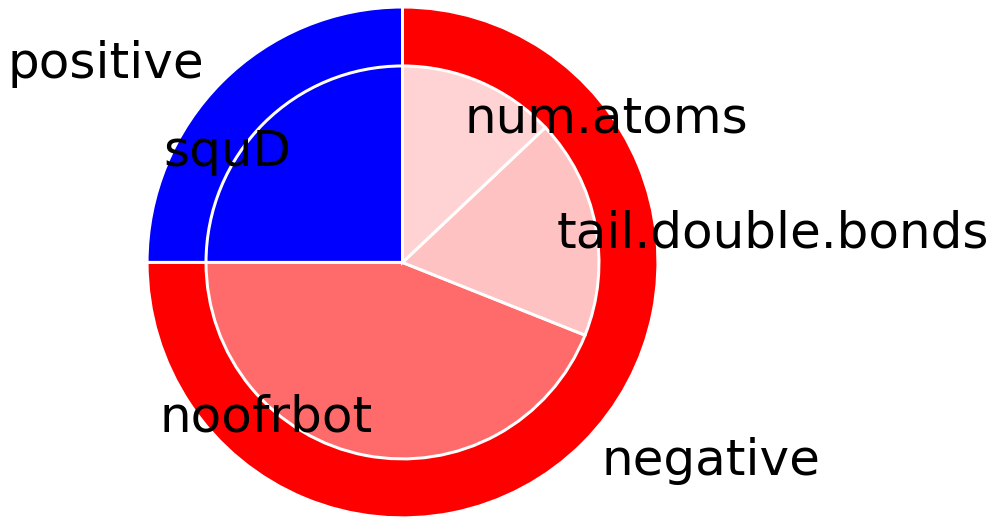

In [78]:
df1 = pd.read_excel('physprops-noRACs1.xlsx')
temp=120
sp=10
cov='med'
df1=df1.loc[(df1['temp']==temp)]
df1=df1.loc[df1['speed']==sp]
df1=df1.loc[df1[cov+'.cov']==1]
rank_features(df1,temp,sp,cov)

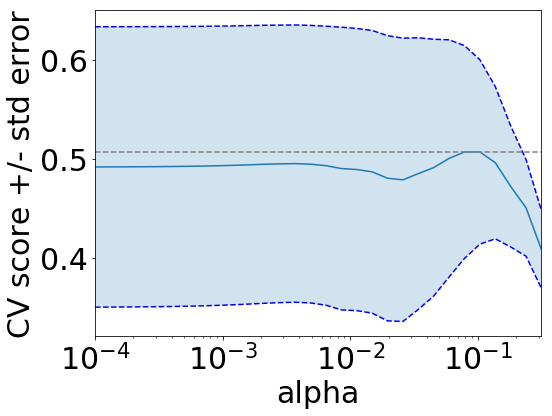

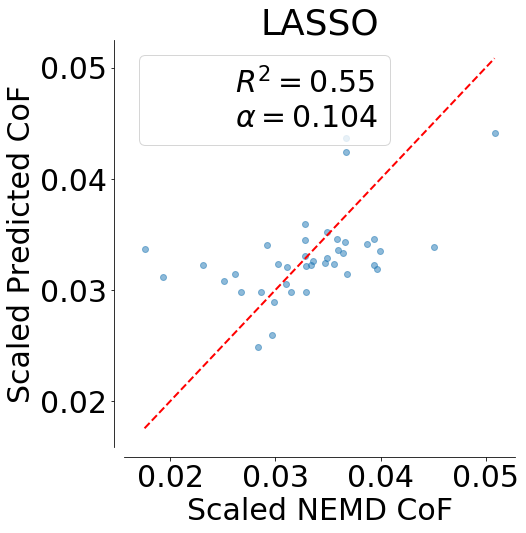

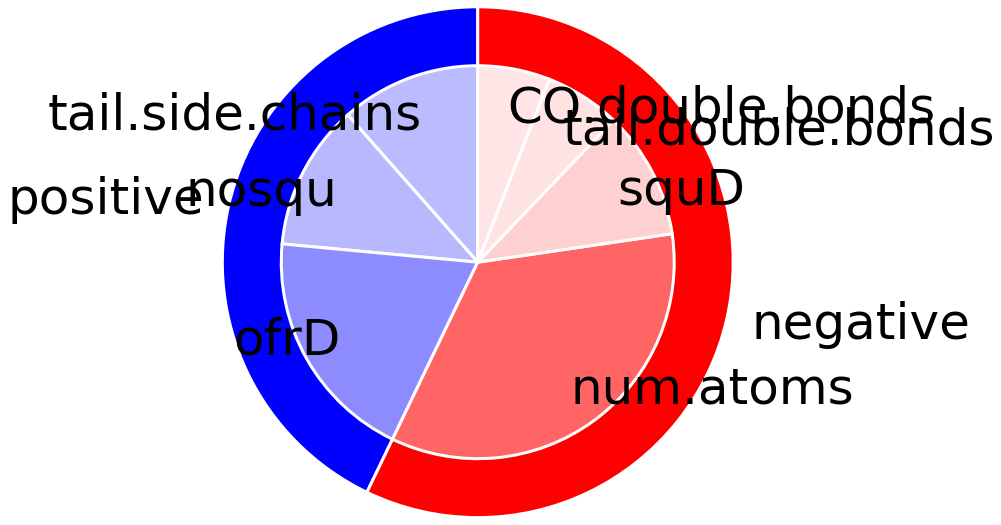

In [79]:
df1 = pd.read_excel('physprops-noRACs1.xlsx')
temp=150
sp=0.5
cov='med'
df1=df1.loc[(df1['temp']==temp)]
df1=df1.loc[df1['speed']==sp]
df1=df1.loc[df1[cov+'.cov']==1]
rank_features(df1,temp,sp,cov)

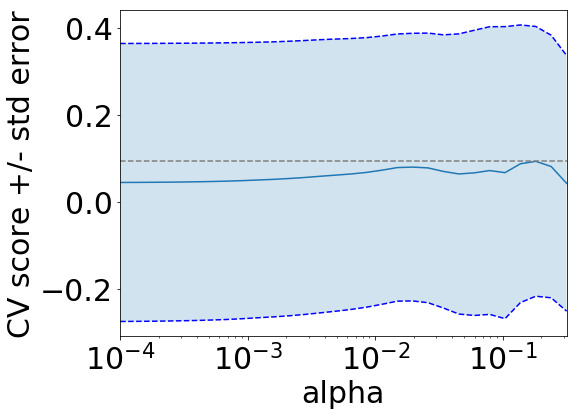

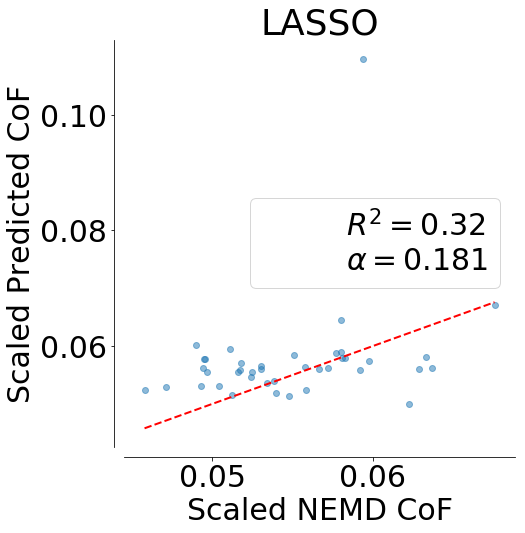

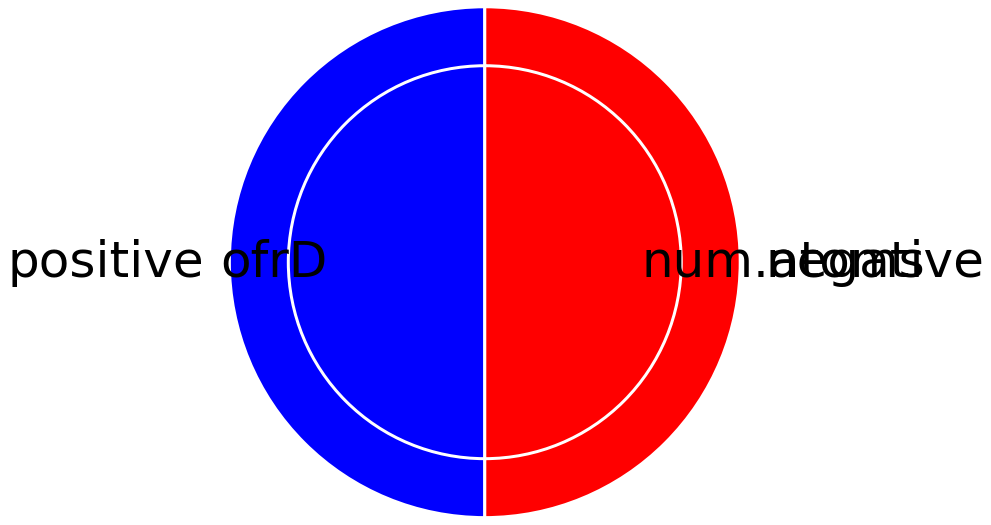

In [80]:
df1 = pd.read_excel('physprops-noRACs1.xlsx')
temp=150
sp=1
cov='med'
df1=df1.loc[(df1['temp']==temp)]
df1=df1.loc[df1['speed']==sp]
df1=df1.loc[df1[cov+'.cov']==1]
rank_features(df1,temp,sp,cov)

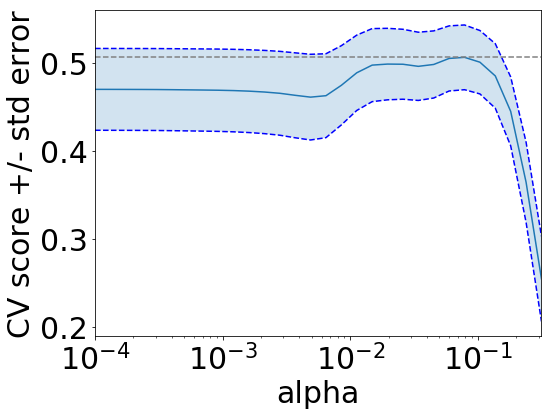

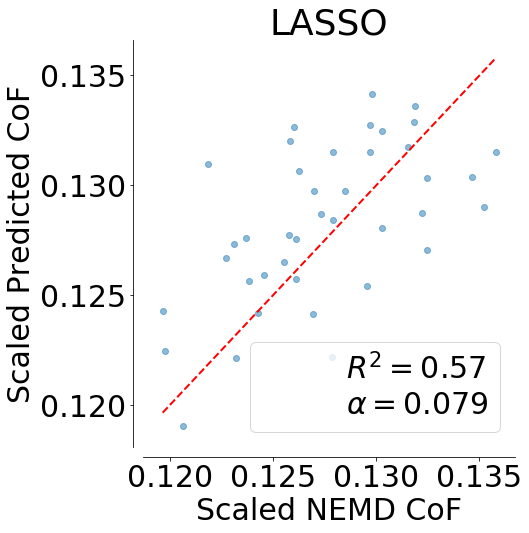

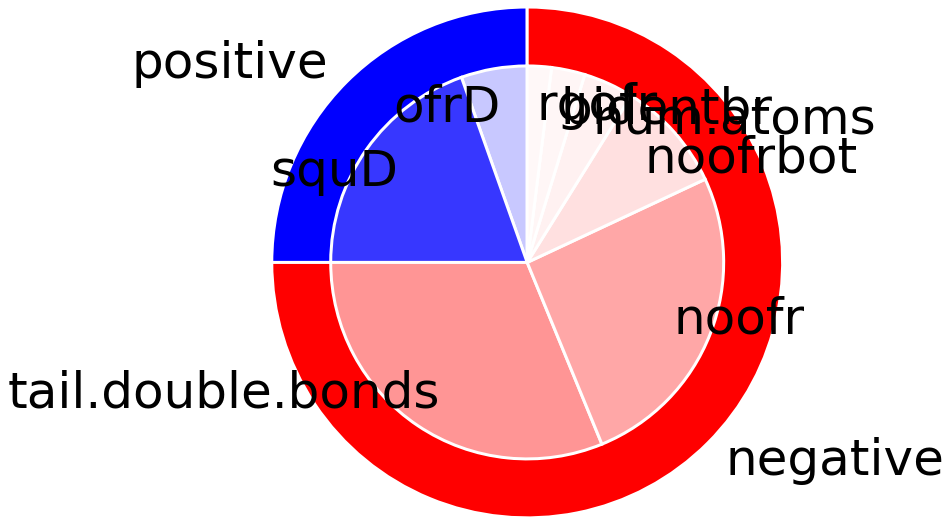

In [81]:
df1 = pd.read_excel('physprops-noRACs1.xlsx')
temp=150
sp=10
cov='med'
df1=df1.loc[(df1['temp']==temp)]
df1=df1.loc[df1['speed']==sp]
df1=df1.loc[df1[cov+'.cov']==1]
rank_features(df1,temp,sp,cov)